# Calculate PCA data using the Ag3 data release

The PCA data files for gamb_colu, arab and gamb_colu_arab (about 5 MB Zarr each) are stored Google Cloud Storage.

A few basic plots are made to eyeball the data before it is stored.

In [1]:
# Imports
import gcsfs
import intake
import pandas as pd
import zarr
import allel
import numpy as np
# For plotting tests:
import matplotlib.pyplot as plt
from bokeh.plotting import *
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20
from IPython.display import HTML

In [2]:
intake.__version__

'0.6.0'

## Settings

In [3]:
# Specify the species groups, used in file names, site filter, region and sample selection
species_groups = ['gamb_colu_arab', 'gamb_colu','arab']

# The number of principal components to process
n_principal_components = 4

# Specify the storage paths
input_alleles_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_umap_input_alleles.zarr'
output_cloud_zarr_path_template = 'vo_agam_production/ag3_data_paper/{}.pca_data.zarr'

In [4]:
def show_memory(self):
  vm = psutil.virtual_memory()
  print(f"{naturalsize(vm.used)} used, {naturalsize(vm.available)} available, {naturalsize(vm.total)} total")

## Check the output doesn't already exist

In [5]:
# Writing the PCA data to the cloud will require the appropriate authentication and authorization.

# UNCOMMENT THIS TO AUTHENTICATE. YOU ONLY NEED TO RUN THIS ONCE.
# After running this once, your authentication token should then be cached in `~/.gcs_tokens`
# Once you have authenticated, you should comment this out again to avoid re-authenticating.
# gcs_browser = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='browser')

# Use `cache_timeout=0` to prevent object list cache, to avoid recreating map for Zarr consolidated metadata
auth_fs = gcsfs.GCSFileSystem(project='malariagen-jupyterhub', token='cache', cache_timeout=0)

# Check that the output's Zarr metadata file is not already on the cloud.
# We don't want to accidentally overwrite or delete existing data, which might have been used in downstream analysis.
# We don't simply check for the existence of the Zarr file here (i.e. output_cloud_zarr_path),
# We might want to re-run the first parts of this notebook again,
# so the Zarr store might legitimately exist but be incomplete.
# The Zarr store is not considered complete until the Zarr metadata file (.zmetadata) is present and correct.
# The final part of this notebook includes steps to create the Zarr metadata file and then validate it.

for species_group in species_groups:
    output_cloud_zarr_path = output_cloud_zarr_path_template.format(species_group)
    output_cloud_zarr_metadata_path = f'{output_cloud_zarr_path}/.zmetadata'
    assert not auth_fs.exists(output_cloud_zarr_metadata_path)

## Get the MalariaGEN Ag1000G data catalog

In [6]:
# Open the MalariaGEN Ag1000G data catalog
cat = intake.open_catalog("https://malariagen.github.io/intake/gcs.yml")

## Get the list of samples sets

In [7]:
df_sample_sets = cat.ag3.sample_sets.read()
print('sample set count:', len(df_sample_sets))
df_sample_sets.head()

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


sample set count: 28


,sample_set,sample_count
0,AG1000G-AO,81
1,AG1000G-BF-A,181
2,AG1000G-BF-B,102
3,AG1000G-BF-C,13
4,AG1000G-CD,76


### Remove the AG1000G-X sample set

The crosses in AG1000G-X are probably not representative.

In [8]:
df_sample_sets = df_sample_sets[df_sample_sets['sample_set'] != 'AG1000G-X']
print('sample set count:', len(df_sample_sets))

sample set count: 27


In [9]:
# Get the sample sets as a Pandas Series.
sample_sets = df_sample_sets['sample_set']

# Eyeball the series.
sample_sets

0       AG1000G-AO
1     AG1000G-BF-A
2     AG1000G-BF-B
3     AG1000G-BF-C
4       AG1000G-CD
5       AG1000G-CF
6       AG1000G-CI
7     AG1000G-CM-A
8     AG1000G-CM-B
9     AG1000G-CM-C
10      AG1000G-FR
11    AG1000G-GA-A
12      AG1000G-GH
13    AG1000G-GM-A
14    AG1000G-GM-B
15    AG1000G-GM-C
16    AG1000G-GN-A
17    AG1000G-GN-B
18      AG1000G-GQ
19      AG1000G-GW
20      AG1000G-KE
21    AG1000G-ML-A
22    AG1000G-ML-B
23      AG1000G-MW
24      AG1000G-MZ
25      AG1000G-TZ
26      AG1000G-UG
Name: sample_set, dtype: object

## Get the metadata for all of the samples

This is used for tooltips on PCA plots, etc.

In [10]:
# Concatenate the sample metadata for all of the sample sets.
df_samples = pd.concat([cat.ag3.samples(sample_set=s).read() for s in sample_sets], axis=0)
print('samples count:', len(df_samples))
df_samples.head()

samples count: 2784


,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call
0,AR0047-C,LUA047,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F
1,AR0049-C,LUA049,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F
2,AR0051-C,LUA051,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F
3,AR0061-C,LUA061,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F
4,AR0078-C,LUA078,Joao Pinto,Angola,Luanda,2009,4,-8.884,13.302,F


## Filter the samples by the relevant species calls

We don't need to filter for gamb_colu_arab, because it should include all samples from all species groups, provided we have excluded the AG1000G-X lab samples, but this step serves as a sanity/consistency check.

### Get the AIM species calls for all samples in the list of sample sets

In [11]:
df_species_aim = pd.concat([cat.ag3.species_calls_20200422_aim(sample_set=s).read() for s in sample_sets], axis=0)
df_species_aim.head()

,sample_id,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii
0,AR0047-C,0.945,0.001,gamb_colu,coluzzii
1,AR0049-C,0.933,0.001,gamb_colu,coluzzii
2,AR0051-C,0.937,0.002,gamb_colu,coluzzii
3,AR0061-C,0.938,0.002,gamb_colu,coluzzii
4,AR0078-C,0.926,0.001,gamb_colu,coluzzii


### Get the species filters

In [12]:
# The set of relevant samples depends on which species_group we're interested in
species_filters = {}
for species_group in species_groups:
    if species_group == 'gamb_colu_arab':
        species_filters[species_group] = df_species_aim['species_gambcolu_arabiensis'].isin(['gamb_colu', 'arabiensis', 'intermediate'])
    elif species_group == 'gamb_colu':
        species_filters[species_group] = df_species_aim['species_gambcolu_arabiensis'].isin(['gamb_colu'])
    elif species_group == 'arab':
        species_filters[species_group] = df_species_aim['species_gambcolu_arabiensis'].isin(['arabiensis'])
    else:
        raise ValueError(f'Unhandled species_group: {species_group}')

In [13]:
# Eyeball the number of samples selected
for species_group in species_groups:
    print(species_group, species_filters[species_group].sum())

gamb_colu_arab 2784
gamb_colu 2415
arab 368


In [14]:
# Eyeball the number of samples filtered out
for species_group in species_groups:
    print(species_group, len(df_samples) - species_filters[species_group].sum())

gamb_colu_arab 0
gamb_colu 369
arab 2416


In [15]:
# For gamb_colu_arab only, check that we haven't filtered out any samples
assert species_filters['gamb_colu_arab'].sum() == len(df_samples)

### Get the sample metadata for the samples via the species filters

In [16]:
df_species_samples_by_species_group = {}
for species_group in species_groups:
    df_species_samples_by_species_group[species_group] = df_samples[species_filters[species_group]]

## Get the allele counts for each species group

In [17]:
allele_count_zarr_stores = {} # Not used, but kept for convenience
allele_count_zarr_groups = {}
for species_group in species_groups:
    allele_count_zarr_stores[species_group] = auth_fs.get_mapper(input_alleles_cloud_zarr_path_template.format(species_group))
    allele_count_zarr_groups[species_group] = zarr.Group(allele_count_zarr_stores[species_group], read_only=True)

## Run the PCA

In [18]:
# NOTE: if this halts with `ValueError: array must not contain infs or NaNs`
# that might be because we've selected a non-segregating variant, where division leads to inf.

In [19]:
%%time
pca_data = {}
for species_group in species_groups:
    print(species_group)
    computed_downsampled_allele_counts = allele_count_zarr_groups[species_group]['allele_counts_pca_ready']
    pca_data[species_group] = {}
    pca_data[species_group]['coords'], pca_data[species_group]['model'] = allel.pca(computed_downsampled_allele_counts, n_components=n_principal_components, scaler='patterson')
# Wall time: 4min 3s

gamb_colu_arab
gamb_colu
arab
CPU times: user 12min 36s, sys: 19.4 s, total: 12min 55s
Wall time: 4min 19s


In [20]:
# Eyeball the coordinates data
for species_group in species_groups:
    print(pca_data[species_group]['coords'])

[[ -23.193724      1.5666333    -6.6000457  -138.57948   ]
 [ -22.138273      3.8411682    -5.6490808  -125.90189   ]
 [ -20.418766      3.0247428    -4.034306   -118.67884   ]
 ...
 [  -2.3232772    26.157904     -0.7326056     1.8850673 ]
 [  -4.5826845    26.332535     -0.16653723    6.072132  ]
 [  -3.8428502    21.192047      4.3393445     2.2650955 ]]
[[ -16.402231    -8.965208  -129.69632      2.9489715]
 [ -17.322542    -8.071077  -134.26373      3.2042477]
 [ -15.927236    -7.412089  -129.6818       4.969664 ]
 ...
 [  29.168945     6.6281834    3.7553194    8.300803 ]
 [  27.560432     6.1247244    3.023282     2.650237 ]
 [  24.461092     5.95559      2.1906536    7.4501834]]
[[-18.657112   222.02129    -52.13638      0.7581915 ]
 [-23.372751   286.11664    -86.218445    10.813683  ]
 [-21.912956   257.54608    -63.240654    22.239527  ]
 ...
 [  6.965544     3.4579728   12.894335   -19.850044  ]
 [  6.558698     7.295915    20.18008    -27.207302  ]
 [  8.649783    -1.18643

In [21]:
# Eyeball the explained variance ratios
for species_group in species_groups:
    print(pca_data[species_group]['model'].explained_variance_ratio_)

[0.00637726 0.00378944 0.00289435 0.0027758 ]
[0.00498083 0.00361252 0.00321538 0.00226845]
[0.010099   0.00586918 0.00473376 0.00452302]


## Avoid the component orientations flipping randomly when re-run

In [22]:
%%time
for species_group in species_groups:
    
    coords = pca_data[species_group]['coords']
    components = pca_data[species_group]['model'].components_
    allele_counts = allele_count_zarr_groups[species_group]['allele_counts_pca_ready']
    
    # To avoid the component orientations flipping randomly when re-run,
    # choose the maximum absolute value for the coords to be positive
    do_inv = []
    for n_pc in range(0, len(components)):
        mx = np.max(coords[:, n_pc])
        mn = np.min(coords[:, n_pc])
        if mx >= -mn:
            do_inv.append(1)
        else:
            do_inv.append(-1)
            
    pca_data[species_group]['polarized_coords'] = np.ndarray(shape=(len(coords), len(components)))
    for n_pc in range(0, len(components)):
        for n_s in range(0, len(coords)):
            pca_data[species_group]['polarized_coords'][n_s, n_pc] = coords[n_s, n_pc] * do_inv[n_pc]
            
    pca_data[species_group]['polarized_components'] = np.ndarray(shape=(len(components), allele_counts.shape[0]))
    for n_pc in range(0, len(pca_data[species_group]['model'].components_)):
        for n_ds in range(0, allele_counts.shape[0]):
            pca_data[species_group]['polarized_components'][n_pc, n_ds] = components[n_pc, n_ds] * do_inv[n_pc]
# Wall time: 4.77 s

CPU times: user 3 s, sys: 9.16 ms, total: 3.01 s
Wall time: 3.23 s


## Eyeball a couple of basic PCA plots

### Matplotlib

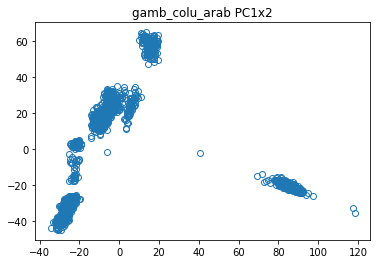

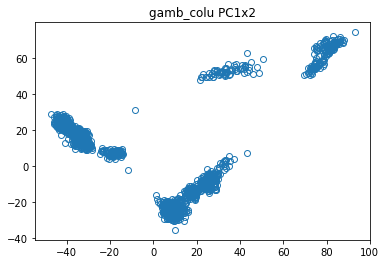

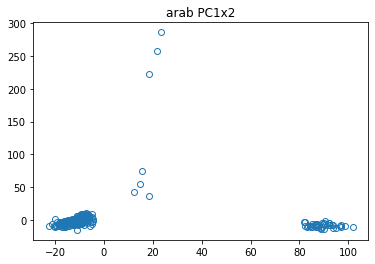

In [23]:
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    fig, ax = plt.subplots()
    ax.plot(polarized_coords[:, 0], polarized_coords[:, 1], marker='o', linestyle=' ', markerfacecolor='none')
    ax.set_title(f'{species_group} PC1x2')

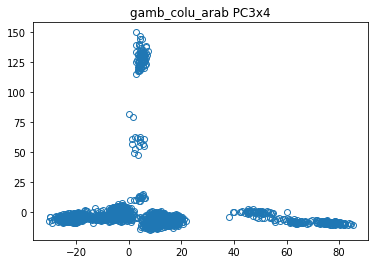

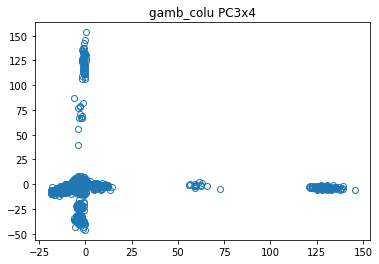

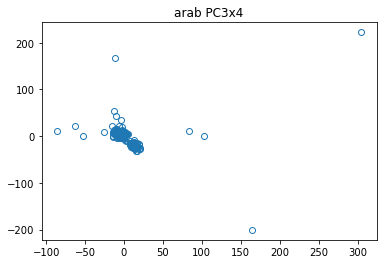

In [24]:
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    fig, ax = plt.subplots()
    ax.plot(polarized_coords[:, 2], polarized_coords[:, 3], marker='o', linestyle=' ', markerfacecolor='none')
    ax.set_title(f'{species_group} PC3x4')

### Bokeh

In [25]:
# Add the PCA coords to the sample metadata DataFrame
for species_group in species_groups:
    for ix, col in enumerate(pca_data[species_group]['polarized_coords'][:].T):
        df_species_samples_by_species_group[species_group]["PC{0}".format(ix + 1)] = col

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [26]:
for species_group in species_groups:
    # Save as a file
    output_file_name = f'PCA_{species_group}.html'
    output_file(output_file_name)

    # The @ identifiers correspond to columns in the sample metadata.
    tooltips = [
        ("sample_id", "@sample_id"),
        ("country", "@country"),
        ("year", "@year"),
        ("(x, y)", "($x, $y)")
    ]
    grid = []
    l = []
    # NOTE: If you don't want strict pairs, remove the step param, i.e.: for i in range(1, n_principal_components):
    for i in range(1, n_principal_components, 2):
        p = figure(plot_width=400, plot_height=400, tooltips=tooltips)

        source = ColumnDataSource(data=df_species_samples_by_species_group[species_group])
        p.circle(
            "PC{0}".format(i), "PC{0}".format(i+1), 
            source=source,
            line_color='black',
            line_width=0.5,
            size=6,
            fill_color=factor_cmap('country', palette=Category20[19], factors=df_species_samples_by_species_group[species_group]['country'].unique())
        )

        p.xaxis.axis_label = "PC{0}".format(i)
        p.yaxis.axis_label = "PC{0}".format(i+1)
        l.append(p)

    grid.append(l)
    col = gridplot(grid)
    show(col)

    # Show the saved file
    HTML(filename=output_file_name)

## Eyeball the explained variance ratio per component

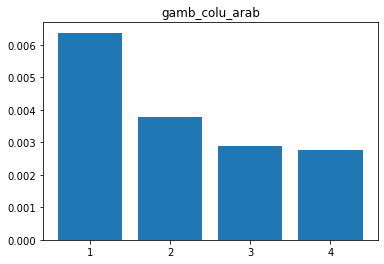

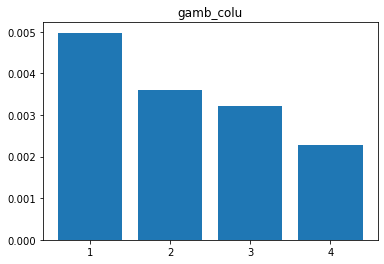

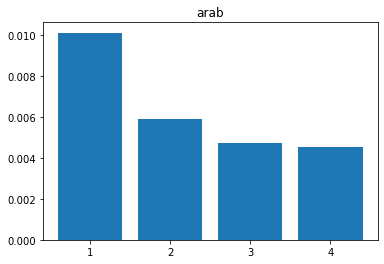

In [27]:
for species_group in species_groups:
    model = pca_data[species_group]['model']
    plt.figure(species_group)
    plt.title(species_group)
    plt.bar(range(n_principal_components), model.explained_variance_ratio_, tick_label=range(1, n_principal_components + 1))

## Store the PCA data

In [28]:
# Check the data types
for species_group in species_groups:
    polarized_coords = pca_data[species_group]['polarized_coords']
    model = pca_data[species_group]['model']
    print(species_group, type(polarized_coords), type(model.explained_variance_ratio_))

gamb_colu_arab <class 'numpy.ndarray'> <class 'numpy.ndarray'>
gamb_colu <class 'numpy.ndarray'> <class 'numpy.ndarray'>
arab <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [30]:
pca_zarr_stores = {}
pca_zarr_groups = {}
for species_group in species_groups:

    output_cloud_zarr_path = output_cloud_zarr_path_template.format(species_group)
    print('Will attempt to store at:', output_cloud_zarr_path)

    # Sometimes errors with `overwrite=True`, sometimes errors without, when dir not exist
    # Keep the pca_zarr_store for zarr.consolidate_metadata(pca_zarr_store)
    pca_zarr_stores[species_group] = auth_fs.get_mapper(output_cloud_zarr_path)
    pca_zarr_groups[species_group] = zarr.group(pca_zarr_stores[species_group])

Will attempt to store at: vo_agam_production/ag3_data_paper/gamb_colu_arab.pca_data.zarr
Will attempt to store at: vo_agam_production/ag3_data_paper/gamb_colu.pca_data.zarr
Will attempt to store at: vo_agam_production/ag3_data_paper/arab.pca_data.zarr


In [31]:
%%time
for species_group in species_groups:
    pca_zarr_group = pca_zarr_groups[species_group]
    polarized_coords = pca_data[species_group]['polarized_coords']
    model = pca_data[species_group]['model']
    df_species_samples = df_species_samples_by_species_group[species_group]
    polarized_components = pca_data[species_group]['polarized_components']
    
    pca_zarr_group.create_dataset("coords", data=polarized_coords, overwrite=True) # overwrite otherwise `ValueError: path 'coords' contains an array`
    pca_zarr_group.create_dataset("explained_variance_ratio", data=model.explained_variance_ratio_, overwrite=True)
    pca_zarr_group.create_dataset("sample_ids", data=df_species_samples['sample_id'].to_list(), overwrite=True)
    pca_zarr_group.create_dataset("components", data=polarized_components, overwrite=True)
    # pca_zarr_group.create_dataset("downsampled_site_indices", data=downsampled_site_indices, overwrite=True)
# Wall time: 11.7 s

CPU times: user 625 ms, sys: 26.2 ms, total: 652 ms
Wall time: 11.7 s


## Check the stored PCA data

In [32]:
%%time
# Check all chunks are initialized
for species_group in species_groups:
    pca_zarr_group = pca_zarr_groups[species_group]
    
    assert pca_zarr_group['coords'].nchunks_initialized == pca_zarr_group['coords'].nchunks
    assert pca_zarr_group['explained_variance_ratio'].nchunks_initialized == pca_zarr_group['explained_variance_ratio'].nchunks
    assert pca_zarr_group['sample_ids'].nchunks_initialized == pca_zarr_group['sample_ids'].nchunks
    assert pca_zarr_group['components'].nchunks_initialized == pca_zarr_group['components'].nchunks
    #assert pca_zarr_group['downsampled_site_indices'].nchunks_initialized == pca_zarr_group['downsampled_site_indices'].nchunks
# Wall time: 1.94 s

CPU times: user 110 ms, sys: 6.04 ms, total: 116 ms
Wall time: 1.94 s


In [33]:
# Check that the pca_zarr_store contains the expected arrays
for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]
    
    assert 'coords/.zarray' in pca_zarr_store
    assert 'explained_variance_ratio/.zarray' in pca_zarr_store
    assert 'sample_ids/.zarray' in pca_zarr_store
    assert 'components/.zarray' in pca_zarr_store
    #assert 'downsampled_site_indices/.zarray' in pca_zarr_store

## Consolidate the Zarr metadata

In [34]:
# Consolidate the metadata
# https://zarr.readthedocs.io/en/stable/api/convenience.html#zarr.convenience.consolidate_metadata
# "Consolidate all metadata for groups and arrays within the given store into a single resource and put it under the given key."
# "This produces a single object in the backend store, containing all the metadata read from all the zarr-related keys that can be found."

for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]
    zarr.consolidate_metadata(pca_zarr_store)

## Check the consolidated Zarr metadata

In [35]:
for species_group in species_groups:
    pca_zarr_store = pca_zarr_stores[species_group]

    # Re-load the consolidated metadata, for validation
    pca_zarr_consolidated_metadata = zarr.open_consolidated(pca_zarr_store)
    
    # Test that the keys of the consolidated metadata are as expected 
    # REM: 'downsampled_site_indices', 
    assert list(pca_zarr_consolidated_metadata.keys()) == ['components', 'coords', 'explained_variance_ratio', 'sample_ids']